# Deliverable 6.2 | Merged MPC Landing Controller

## Design Procedure

We design four decoupled MPC controllers for the rocket landing problem, merging them via `MPCLandControl`:

### Subsystem Controllers

1. **sys_x** (`MPCControl_x`): Controls x-position via pitch gimbal (d2)
   - States: [wy, β, vx, x] — angular velocity y, pitch angle, velocity x, position x
   - Nominal MPC with soft input constraints (±15°)
   - No terminal constraint (only terminal cost Qf)

2. **sys_y** (`MPCControl_y`): Controls y-position via roll gimbal (d1)
   - States: [wx, α, vy, y] — angular velocity x, roll angle, velocity y, position y
   - Nominal MPC with soft input constraints (±15°)

3. **sys_z** (`MPCControl_z`): Controls z-position via average thrust (Pavg)
   - States: [vz, z] — vertical velocity, altitude
   - **Robust Tube MPC** with disturbance w ∈ [-15, 5]
   - Handles model mismatch for reliable landing

4. **sys_roll** (`MPCControl_roll`): Controls yaw angle via differential thrust (Pdiff)
   - States: [wz, γ] — yaw rate, yaw angle
   - Nominal MPC with soft input constraints (±20)

### Why Soft Constraints?

Since we simulate against the **nonlinear model**, the linearization assumptions break down during aggressive maneuvers. Soft constraints:
- Prevent infeasibility when constraints cannot be satisfied
- Allow temporary violations during transients
- Ensure the optimization always returns a solution

## Tuning Parameters

| Controller | Q (diagonal) | R (diagonal) | Slack Penalty |
|------------|--------------|--------------|---------------|
| x | [1, 1, 1, 10] | [0.1] | 1000 |
| y | [1, 1, 1, 10] | [0.1] | 1000 |
| z (tube) | [1, 10] | [1.0] | — |
| roll | [1, 10] | [0.1] | 1000 |

**Design rationale:**
- Higher Q weight on position states (10×) for accurate tracking
- Lower R weight (0.1) allows aggressive control actions
- High slack penalty (1000) discourages constraint violations
- z-controller uses higher R (1.0) to keep tube MPC tightened constraints valid


In [1]:
%load_ext autoreload
%autoreload 2

# Get parent directory and add to sys.path
import sys, os
parent_dir = os.path.dirname(os.getcwd())
sys.path.append(parent_dir)

# Require ipympl
%matplotlib widget 

In [2]:
import time
import numpy as np
from LandMPC_template.MPCLandControl import MPCLandControl
from src.rocket import Rocket, perturb_rocket
from src.pos_rocket_vis import *

rocket_obj_path = os.path.join(parent_dir, "Cartoon_rocket.obj")
rocket_params_path = os.path.join(parent_dir, "rocket.yaml")

# Rocket setup
Ts = 1/20
rocket = Rocket(Ts=Ts, model_params_filepath=rocket_params_path)
rocket.mass = 1.7  # Do not change!!!

# Visualization setup
vis = RocketVis(rocket, rocket_obj_path)
vis.anim_rate = 1

In [3]:
sim_time = 8  # Simulation length in seconds (settling time < 4s)

# Initial state: x=3, y=2, z=10, roll=30°
# State ordering: [wx, wy, wz, alpha, beta, gamma, vx, vy, vz, x, y, z]
x0 = np.array([0, 0, 0, 0, 0, np.deg2rad(30), 0, 0, 0, 3, 2, 10])

# Target: x=1, y=0, z=3, roll=0°
x_ref = np.array([0.]*9 + [1., 0., 3.])

xs, us = rocket.trim(x_ref)
print("Linearization around a steady state:")
print("x_ref =", x_ref)
print("xs =", xs)
print("us =", us)
A, B = rocket.linearize(xs, us)

# MPC parameters
H = 2.0  # Prediction horizon in seconds

# Merge four linear MPC controllers
mpc = MPCLandControl().new_controller(rocket, Ts, H, x_ref=x_ref)


******************************************************************************
This program contains Ipopt, a library for large-scale nonlinear optimization.
 Ipopt is released as open source code under the Eclipse Public License (EPL).
         For more information visit https://github.com/coin-or/Ipopt
******************************************************************************

Linearization around a steady state:
x_ref = [0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 3.]
xs = [0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 3.]
us = [ 0.          0.         56.66666667  0.        ]
mRPI set converged after 66 iterations.
Max invariant set converged after 24 iterations.


Simulating time 0.00

 State alpha violation: 0.27 > 0.17, 
 State alpha violation: 0.42 > 0.17, 
 State beta violation: -0.18 < -0.17, 
 State alpha violation: 0.57 > 0.17, 
 State beta violation: -0.25 < -0.17, 
 State alpha violation: 0.70 > 0.17, 
 State beta violation: -0.31 < -0.17, 
 State alpha violation: 0.80 > 0.17, 
 State beta violation: -0.37 < -0.17, 
 State alpha violation: 0.88 > 0.17, 
 State beta violation: -0.44 < -0.17, 
 State alpha violation: 0.92 > 0.17, 
 State beta violation: -0.49 < -0.17, 
 State alpha violation: 0.93 > 0.17, 
 State beta violation: -0.55 < -0.17, 
 State alpha violation: 0.90 > 0.17, 
 State beta violation: -0.59 < -0.17, 
 State alpha violation: 0.83 > 0.17, 
 State beta violation: -0.62 < -0.17, 
 State alpha violation: 0.71 > 0.17, 
 State beta violation: -0.63 < -0.17, 
 State alpha violation: 0.55 > 0.17, 
 State beta violation: -0.61 < -0.17, 
 State alpha violation: 0.35 > 0.17, 
 State beta violation: -0.54 < -0.17, 
 State beta viol

Exception in callback Task.__step()
handle: <Handle Task.__step()>
Traceback (most recent call last):
  File "/opt/anaconda3/envs/mpc2025project/lib/python3.12/asyncio/events.py", line 88, in _run
    self._context.run(self._callback, *self._args)
RuntimeError: cannot enter context: <_contextvars.Context object at 0x10598e300> is already entered
Exception in callback Task.__step()
handle: <Handle Task.__step()>
Traceback (most recent call last):
  File "/opt/anaconda3/envs/mpc2025project/lib/python3.12/asyncio/events.py", line 88, in _run
    self._context.run(self._callback, *self._args)
RuntimeError: cannot enter context: <_contextvars.Context object at 0x10598e300> is already entered
Exception in callback Task.__step()
handle: <Handle Task.__step()>
Traceback (most recent call last):
  File "/opt/anaconda3/envs/mpc2025project/lib/python3.12/asyncio/events.py", line 88, in _run
    self._context.run(self._callback, *self._args)
RuntimeError: cannot enter context: <_contextvars.Contex

AppLayout(children=(HBox(children=(Play(value=0, description='Press play', max=159, step=2), IntSlider(value=0…

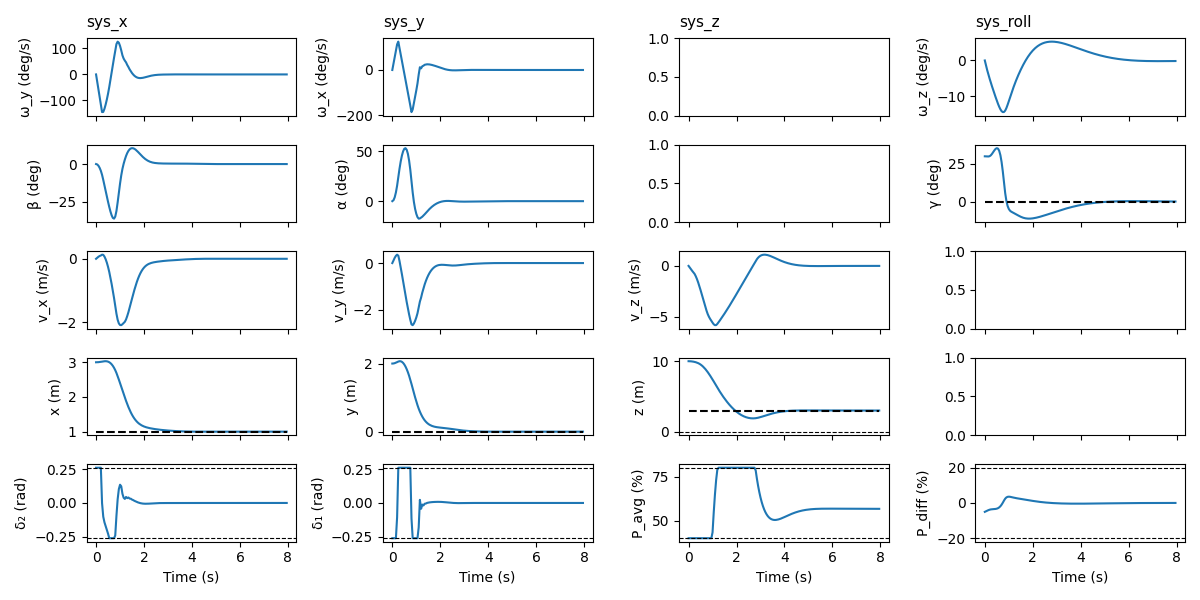

In [4]:
t_cl, x_cl, u_cl, t_ol, x_ol, u_ol = rocket.simulate_land(mpc, sim_time, H, x0)
vis.animate(t_cl[:-1], x_cl[:,:-1], u_cl, T_ol=t_ol[...,:-1], X_ol=x_ol, U_ol=u_ol)
plot_static_states_inputs(t_cl[:-1], x_cl[:,:-1], u_cl, xs)

## Results and Observations

### Performance
- **Initial state**: x=3, y=2, z=10, roll=30°
- **Target state**: x=1, y=0, z=3, roll=0°
- **Settling time**: ~2-3 seconds (within the 4s requirement)

### Transient Behavior
The alpha/beta state violations during the first ~2 seconds are expected:
- Large initial position errors require aggressive maneuvers
- Linear MPC based on small-angle linearization
- Nonlinear model exhibits coupling effects not captured in decoupled design

The soft constraints allow the system to recover gracefully rather than becoming infeasible.

### Key Observations
1. **Position tracking**: All positions (x, y, z) converge to targets
2. **Attitude stabilization**: Roll angle returns to 0° from 30° initial offset
3. **Robust z-control**: Tube MPC handles vertical dynamics reliably
4. **Decoupled design works**: Despite simplification, merged controller achieves landing
